<style>

h1 {
    color: #fff;
    text-align: center;
    font-size: 80px;
    margin-bottom: 40px;
    margin-top: 60px;
}


p {
    color:#fff;
    font-size: 24px;
    text-align: center;
    margin-bottom: 10px;
}

.details {
    border: 2px solid #fff;
    padding: 20px;
    border-radius: 60px;
    margin: auto;
    max-width: 600px;
    margin-bottom: 30px;
}
</style>

<h1>Customer Churn</h1>

<div class="details">
    <p><strong>Integrantes:</strong> Brayan Garzón, Kevin Güiza, Julian Páez</p>
    <p><strong>Curso:</strong> Machine Learning UIFCE</p>
    <p><strong>Fecha:</strong> Julio de 2023</p>
</div>

# Modelo para Customer Churn

In [43]:
# Importar paquetes
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")
from utility import plot_settings

import warnings

warnings.filterwarnings("ignore")

# Machine Learning
## Preprocesamiento
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Modelos de Clasificación
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Métricas de Evaluación
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    balanced_accuracy_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
)

In [21]:
# Carga de datos
data = pd.read_csv('../data/Customer_Churn.csv', sep=';')

In [22]:
# Eliminamos la variable que no aporta información relevante (identificador de cliente)
df = data.copy()
df.drop(columns='CustomerID', inplace=True)

In [23]:
data = data.dropna()

In [24]:
data.shape

(440832, 11)

## 1. Preprocesamiento

- **Tipo de datos de cada variable:**
    - Float64: Age, Usage Frequency, Support Calls, Payment Delay, Total Spend, Last Interaction, Churn.
    - Object: Gender, Subscription Type, Contract Length.

  Podría considerarse la posibilidad de tratar a Support Calls como una variable categórica. Sin embargo, esto generaría al menos 9 variables nuevas, y podría considerarse que esto afecta la parsimonía del modelo. Así, la única variable numérica en realidad categórica es la variable objetivo (que ya está codificada)

### 1.1. Estandarización

In [25]:
numeric_cols = ['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend', 'Last Interaction']

data_num = data[numeric_cols]
data_num.shape

(440832, 6)

In [26]:
# Crear instancia StandardScaler
scaler = StandardScaler()

# Estandarizar las variables
X_scaled = scaler.fit_transform(data_num)

# Dimensiones de los datos estandarizados
X_scaled.shape

(440832, 6)

La conservación de las dimensiones nos demuestra que el proceso de escalamiento no afectó la dimensión del dataset. Para tal proceso se utilizó el standard scaler [¿este escalador es el más apropiado para los datos?]

### 1.2. Codificación

In [27]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

data_cat = data[cat_cols]
data_cat.shape

(440832, 3)

In [28]:
# Codificación
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(data_cat)

# Cantidad de características generadas
X_encoded.shape

(440832, 5)

In [29]:
# Características categóricas codificadas
encoder.get_feature_names_out()

array(['Gender_Male', 'Subscription Type_Premium',
       'Subscription Type_Standard', 'Contract Length_Monthly',
       'Contract Length_Quarterly'], dtype=object)

El codificador generó 2 categorías adicionales para tipo de suscripción y duración de contrato.

### 1.3. Concatenación

In [30]:
# Características a modelar
X = np.concatenate((X_scaled, X_encoded), axis=1)
X.shape

(440832, 11)

In [31]:
# Conservar nombres de las características
feature_names = numeric_cols\
                + encoder.get_feature_names_out()\
                         .tolist()

### 1.4. Serie objetivo

In [32]:
encoder_y = OneHotEncoder(sparse_output=False, drop='if_binary')
y = encoder_y.fit_transform(data['Churn'].values.reshape(-1, 1))

y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

### 1.5. Partición

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=31415)

print("\nShape de los conjuntos de entrenamiento:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nShape de los conjuntos de prueba:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)




Shape de los conjuntos de entrenamiento:
X_train: (352665, 11)
y_train: (352665, 1)

Shape de los conjuntos de prueba:
X_test: (88167, 11)
y_test: (88167, 1)


### 1.6. Balanceo

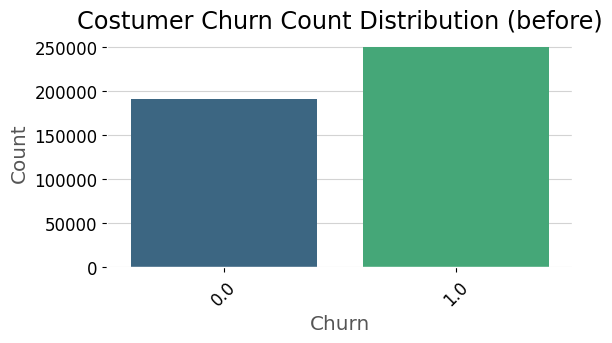

In [34]:
# Graficar antes
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.title('Costumer Churn Count Distribution (before)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [35]:
# Balanceo con sobremuestreo SMOTE
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train)

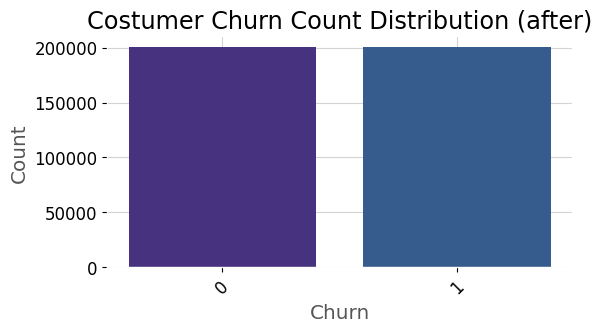

In [36]:
# Graficar luego
class_counts = pd.Series(y_train_balance).value_counts()

plt.figure(figsize=(6, 3))
plt.bar(class_counts.index, class_counts, color=sns.color_palette('viridis'))
plt.xticks(range(2))
plt.title('Costumer Churn Count Distribution (after)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 2. Entrenamiento

### 2.1. Algoritmos a utilizar
1. XGBoostClassifier
2. RandomForest
3. LightGM

### 2.2. Búsqueda de parámetros y validación cruzada
¿Por qué decidió usar la técnica que escogió?

Se propone generar un análisis comparativo utilizando diferentes modelos, tales como: 
- XGBoost (Modelo avanzado que utiliza el método de aumento de gradiente para mejorar la precisión en tareas de clasificación),
- Random Forest (Es un conjunto de árboles de decisión que trabajan juntos para mejorar la precisión en la clasificación) 
- LightGM (Es una implementación eficiente de gradient boosting que se enfoca en la velocidad y el uso eficiente de memoria. )

El objetivo de este análisis es determinar cuál de estos modelos logra predecir de manera más efectiva y precisa. Se considerará su desempeño en la tarea de identificar el comportamiento de churn en un conjunto de datos dado. Cada uno de estos modelos tiene sus propias características y ventajas, por lo que es importante evaluar su rendimiento en relación con los datos y los objetivos específicos del proyecto.

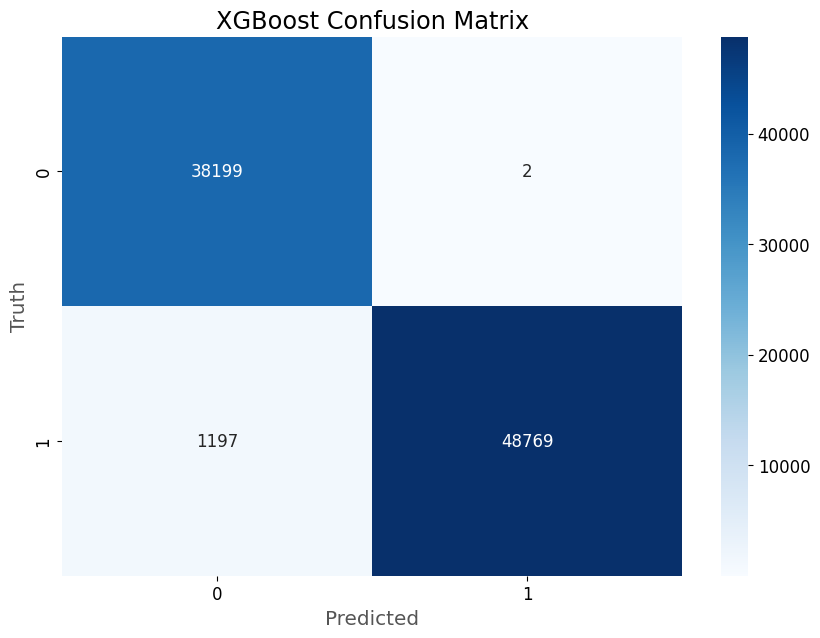

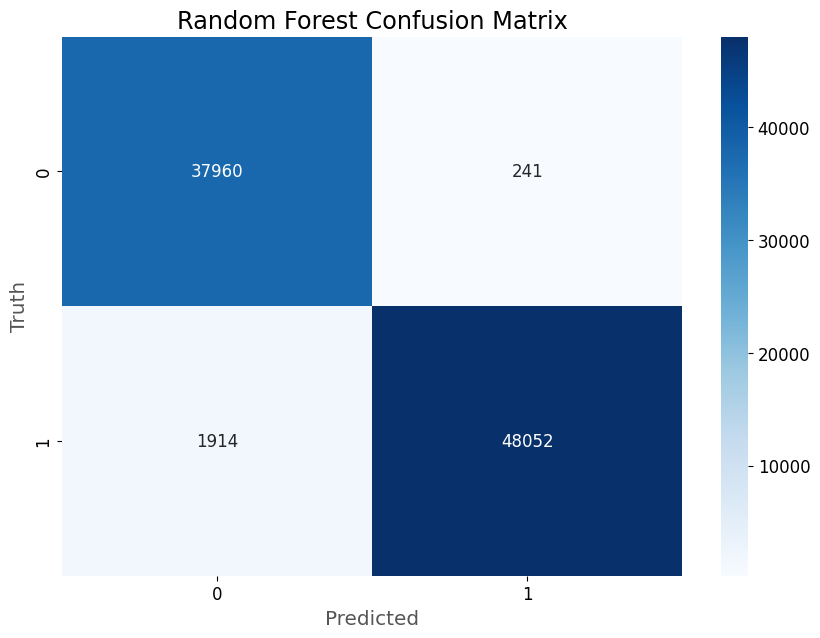

[LightGBM] [Info] Number of positive: 200033, number of negative: 152632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567204 -> initscore=0.270453
[LightGBM] [Info] Start training from score 0.270453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

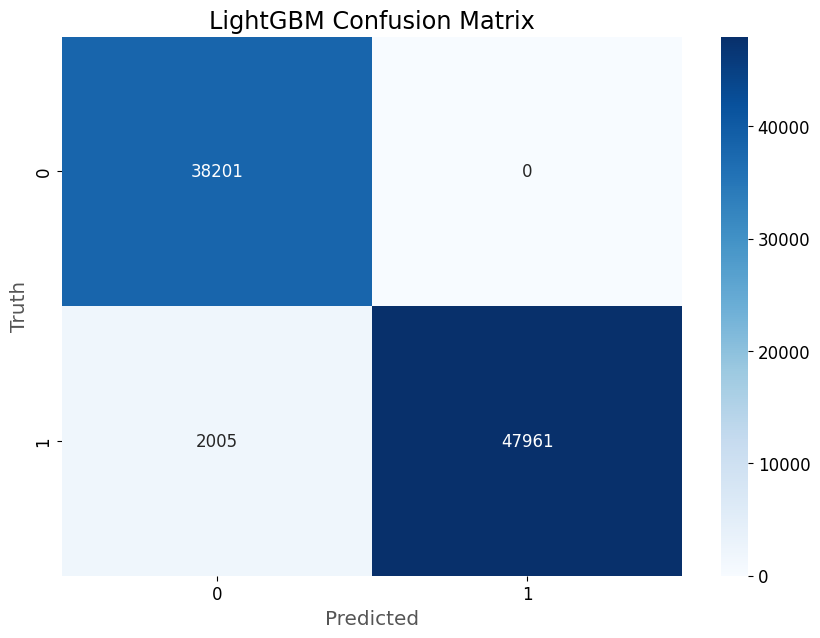

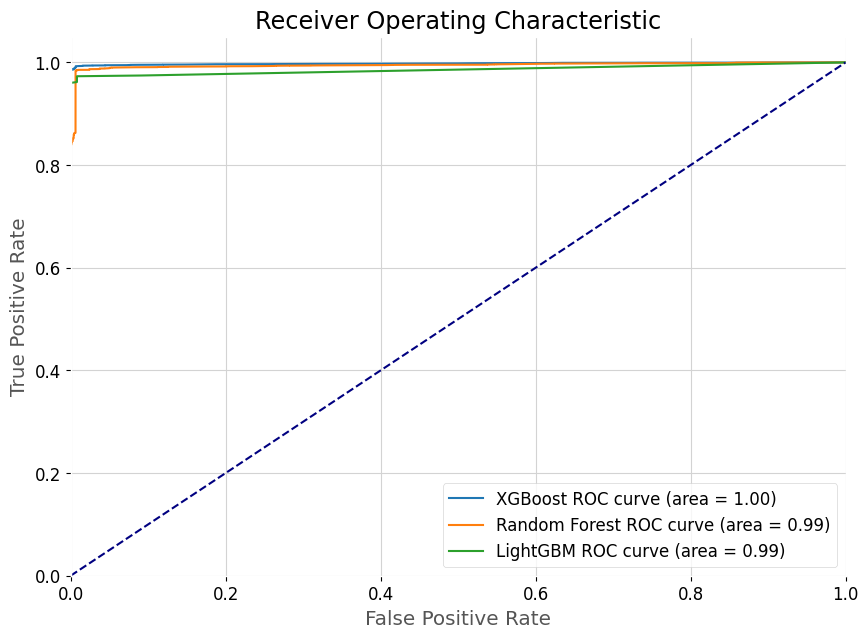

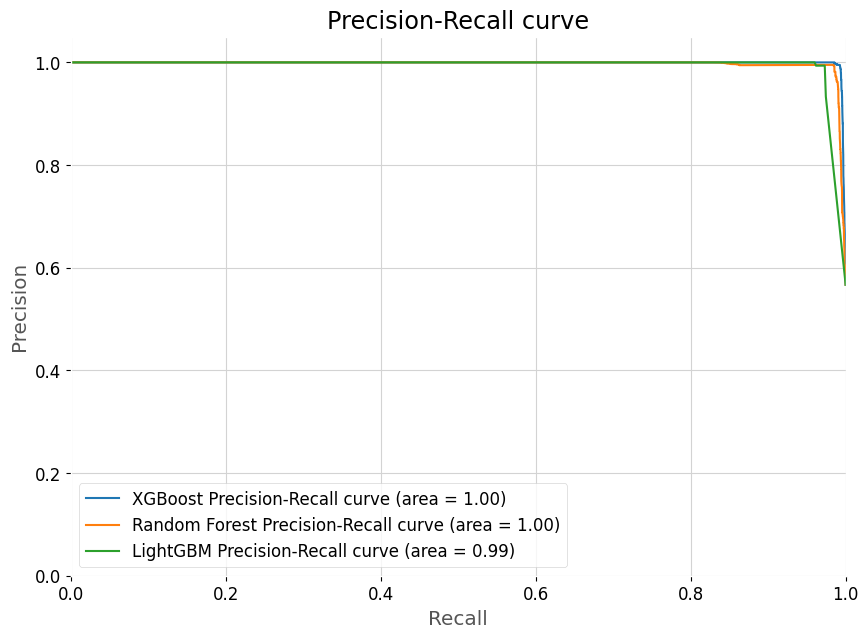

In [37]:
# Define classifiers
classifiers = {
    "XGBoost": XGBClassifier(
        learning_rate=0.01,
        colsample_bytree=0.4,
        subsample=0.8,
        objective="binary:logistic",
        n_estimators=1000,
        reg_alpha=0.3,
        max_depth=4,
        gamma=10,
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=1000,
        max_depth=4,
    ),
    "LightGBM": lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=100,
        max_depth=4,    
    ),
}


roc_data = []

# Fit, predict and compute ROC curve for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Save ROC data
    roc_data.append((fpr, tpr, roc_auc, name))

    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


# Initialize the plot for the ROC curve
plt.figure(figsize=(10, 7))

# Plot ROC curve for each classifier
for fpr, tpr, roc_auc, name in roc_data:
    plt.plot(fpr, tpr, label="%s ROC curve (area = %0.2f)" % (name, roc_auc))

# Finalize the plot for the ROC curve
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10, 7))

# Compute Precision-Recall and plot curve for each classifier
for name, clf in classifiers.items():
    y_score = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.plot(
        recall,
        precision,
        label="%s Precision-Recall curve (area = %0.2f)" % (name, average_precision),
    )

# Set labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="lower left")

plt.show()

## 4. Interpretación de resultados

En este proyecto, se abordó el desafío de predecir el customer churn, es decir, identificar a los clientes que podrían dejar de utilizar un servicio o producto. Para ello, se emplearon tres técnicas de aprendizaje automático: XGBoost, Random Forest y LightGBM. El objetivo era determinar cuál de estos modelos ofrece el mejor rendimiento en términos de precisión de predicción y capacidad de generalización.

En este caso los tres modelos, XGBoost, Random Forest y LightGBM, mostraron un excelente rendimiento en la predicción del customer churn. Todos ellos demostraron ser capaces de predecir perfectamente todos los casos.

### Interpretación de las Matrices de Confusión y el Área bajo la Curva (AUC-ROC):

Las matrices de confusión que nos ayudan para evaluar el rendimiento de los modelos de clasificación, en este caso muestra que esta prediciendo la tasa de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos de una manera muy acertada

El Área bajo la Curva (AUC) de la Curva ROC es una métrica comúnmente utilizada para evaluar la habilidad discriminativa de un modelo de clasificación. Cuanto mayor sea el valor del AUC, mejor será la capacidad del modelo para distinguir entre clases, en este caso las curvas ocupan toda el area.

### Elección del Mejor Modelo:

Dado que los tres modelos lograron predecir perfectamente todos los casos de customer churn, la elección del mejor modelo se basará en otros factores como la eficiencia computacional y la escalabilidad. En este caso, se eligió XGBoost debido a amplia adopción en la industria.

En resumen, este proyecto logró su objetivo de predecir el customer churn utilizando técnicas de aprendizaje automático avanzado. Los modelos XGBoost, Random Forest y LightGBM demostraron ser altamente efectivos en esta tarea, y aunque todos obtuvieron resultados certeros en este conjunto de datos.

# Another aproach
En este apartado queremos hacer uso de diferentes tecnicas a las anteriormente planteadas, en este caso queremos hacer uno de Regresion logistica, un K vecinos mas cercanos y un acercamiento con deep learning usando redes neuronales.

In [38]:

# Definir una malla de hiperparámetros
knn_grid = {'n_neighbors':range(4, 6)}

# Establecer el GS-CV
knn_gs_cv = GridSearchCV(KNeighborsClassifier(),
                         param_grid=knn_grid,
                         cv=5,
                         verbose=1,
                         scoring='recall',
                         return_train_score=True)
                         
knn_gs_cv.fit(X_train_balance, y_train_balance)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(4, 6)}, return_train_score=True,
             scoring='recall', verbose=1)

In [39]:
knn_gs_cv.best_score_

0.936950402649191

In [40]:
knn_gs_cv.best_params_


{'n_neighbors': 5}

In [48]:
y_pred_knn = knn_gs_cv.best_estimator_.predict(X_test)
print('REPORTES DE CLASIFICACIÓN (PRUEBA)')
print('KNN')
print("Accurcy: ", accuracy_score(y_test, y_pred_knn))   
print(classification_report(y_test, y_pred_knn))
print(f'{"-"*60}\n')

REPORTES DE CLASIFICACIÓN (PRUEBA)
KNN
Accurcy:  0.9654859527941293
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     38201
         1.0       1.00      0.94      0.97     49966

    accuracy                           0.97     88167
   macro avg       0.96      0.97      0.97     88167
weighted avg       0.97      0.97      0.97     88167

------------------------------------------------------------



Es interesante observar que los resultados del algoritmo de vecinos más cercanos (KNN) no difieren mucho de lo que se discutió anteriormente y que, a pesar de que la precisión general es alta, encontraste que los modelos de árboles de decisión son equivalentes para esta tarea de clasificación.

Los resultados que presentados parecen respaldar la idea de que KNN es un algoritmo óptimo para este tipo de tarea en nuestro conjunto de datos.

In [44]:
# Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
# Prediction
y_pred = clf.predict(X_test)
 
print("Accurcy: ", accuracy_score(y_test, y_pred))             
print(classification_report(y_test, y_pred))

Accurcy:  0.8957773316547007
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     38201
         1.0       0.93      0.89      0.91     49966

    accuracy                           0.90     88167
   macro avg       0.89      0.90      0.89     88167
weighted avg       0.90      0.90      0.90     88167



### Explicacion de metricas obtenidas.

- Accuracy(Exactitud):
    El accuracy nos habla sobre el promedio general de aciertos en todas las predicciones, asi que alrededor del 90% de los casos el modelo predijo correctamente. Comparado con los anteriores modelos no se ha desempañado mejor.

- Precision:
    Este concepto se refiere a la proporción de predicciones positivas que son realmente correctas, en este caso el 93% de las veces que el modelo predijo que el cliente abandona la compañía esta siento acertada su predicción.

- Recall:
    El Recall mide en que proporcion de los casos reales positivos se identificaron correctamente.

- F1-Score:
    Este conceptop es la combinación entre Precision y Recall, es útil cuando queremos encontrar un equilibrio, en este caso es una medida bastante buena del 0.91


In [45]:
# Create a Multi-layer Perceptron classifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9972552088649949
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     38201
         1.0       1.00      1.00      1.00     49966

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



### Comparacion de los resultados y comentarios finales

Los resultados usando redes neuronales han sido los mejores resultados, sugiriendo que el modelo está realizando una clasificacion casi perfecta, siendo estos los mas sobresalientes.

Despues de probar 5 modelos diferentes para este problema de clasificacion, es importante considerar si los resultados son realistas o existe algún problema de sobreajusto o sesgo en los datos

La alta precisión lograda podría sugerir una coincidencia perfecta entre el modelo y los datos de entrenamiento, llevando a un sobreajuste. También es fundamental considerar la calidad y la representatividad de los datos utilizados en el entrenamiento del modelo, que claramente tambien se trato los datos desequilibrados.

En resumen aunque los resultados de las redes neuronales parecen extremadamente prometedores, es crucial seguir explorando y mejorando nuestro enfoque para garantizar que los resultados sean confiables y lo suficiente generalizables en situaciones del mundo real.